In [4]:
#Import modules
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import shuffle
from scipy import interp
import statistics as st
import neurolab as nl
import math
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal

In [5]:
def prepare_subplot(i, j, height, width):
    """Set subplot framework"""
    f, axarr = plt.subplots(i,j)
    f.set_figheight(height)
    f.set_figwidth(width)
    return f, axarr

In [6]:
def roc_function(y_score, y_test, k, axarr):
    """Compute roc curves and prepare plot"""
# Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
        ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plot_places = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2),(3,0),(3,1),(3,2)]
    axarr[plot_places[k]].plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             linewidth=2)

    axarr[plot_places[k]].plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             linewidth=2)

    for i in range(n_classes):
        axarr[plot_places[k]].plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'
                                       ''.format(i + 1, roc_auc[i]))

    axarr[plot_places[k]].plot([0, 1], [0, 1], 'k--')
    axarr[plot_places[k]].set_xlim([0.0, 1.0])
    axarr[plot_places[k]].set_ylim([0.0, 1.05])
    
    if plot_places[k][0] == 3:
        axarr[plot_places[k]].set_xlabel('False Positive Rate')
    if plot_places[k][1] == 0:
        axarr[plot_places[k]].set_ylabel('True Positive Rate')
        
    axarr[plot_places[k]].set_title('Subject {0}'.format(k + 1))
    axarr[plot_places[k]].legend(loc='lower right', fontsize = 'x-small')
    
    return

In [7]:
#Get data of all subjects and put it in lists
subjects = range(1,13)
feattr_all = []
labels_all = []
for subject in subjects:
    #Load data
    filename = "train_filtered/filtered_"+str(subject)+".npz"
    datas = np.load(filename)
    feattr = datas['arr_0']
    labels = datas['arr_1']
    
    #Reshape data
    feattr = np.transpose(feattr)
    labels = np.transpose(labels)
    feattr_all.append(feattr)
    labels_all.append(labels)
    n_classes = labels.shape[1]
       
print('Done')    
    

Done


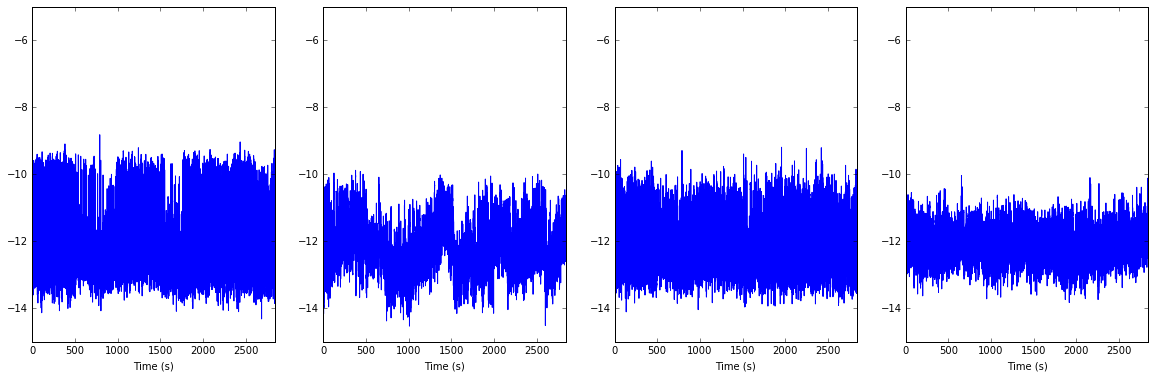

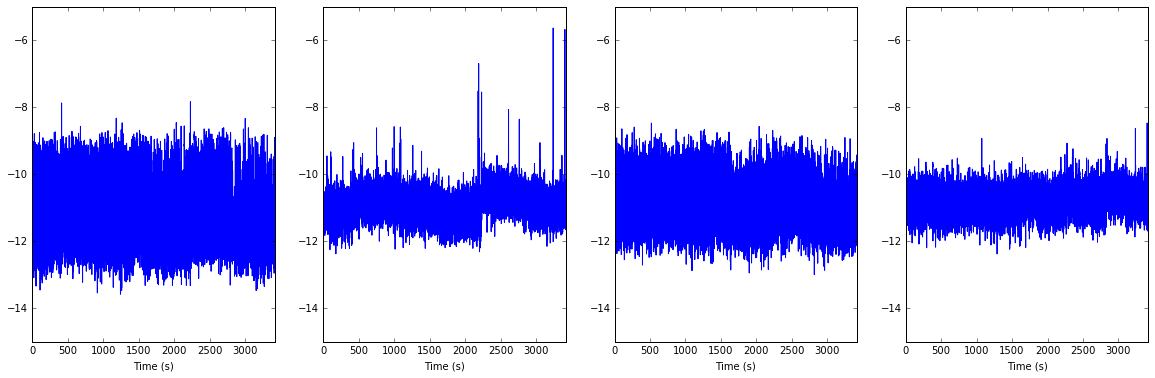

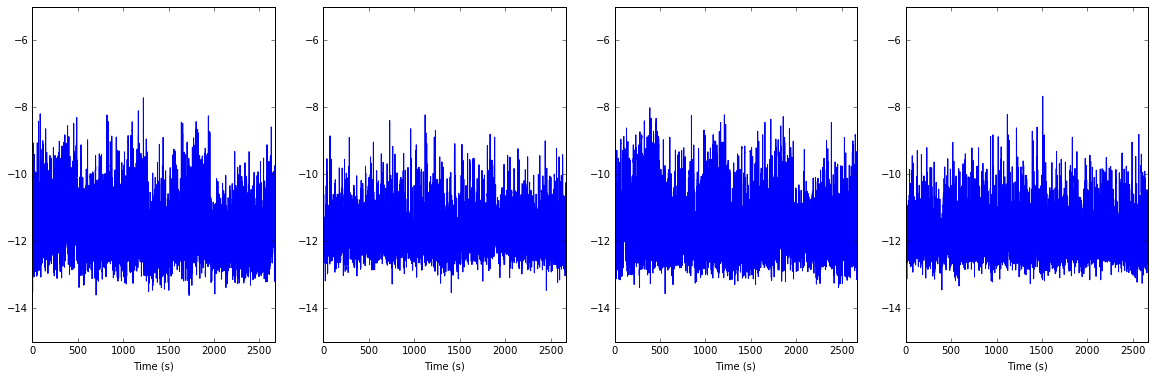

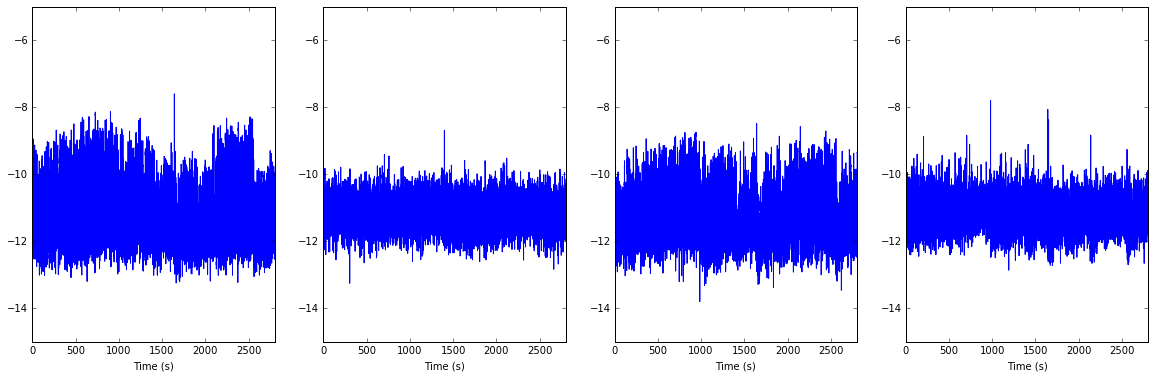

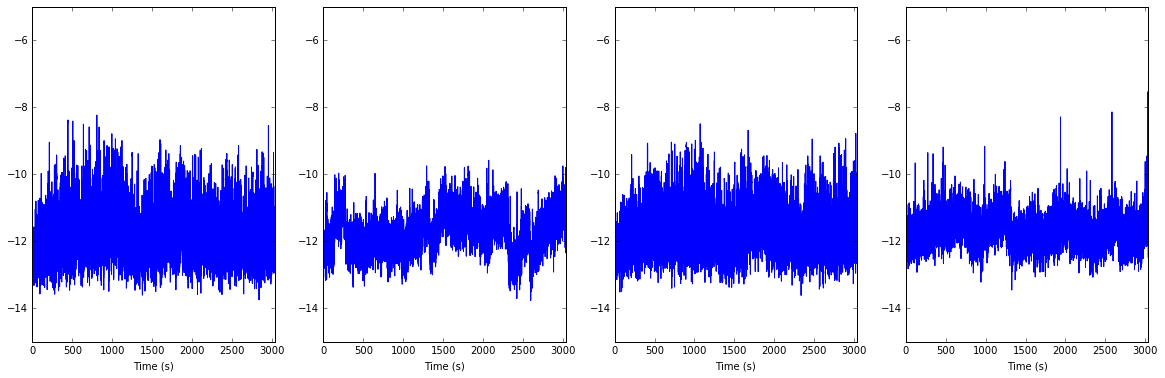

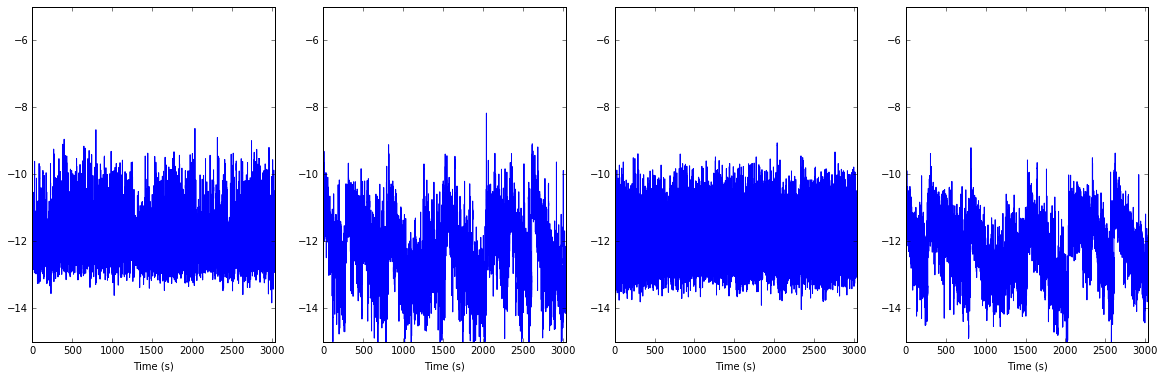

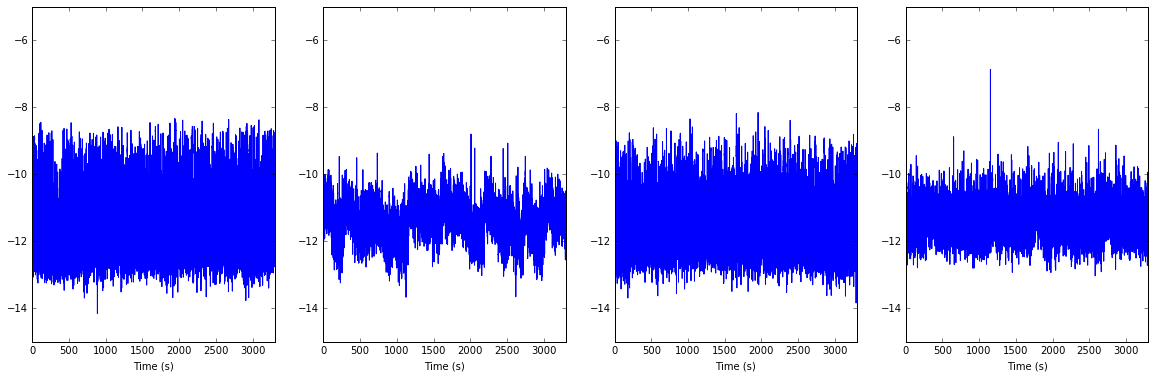

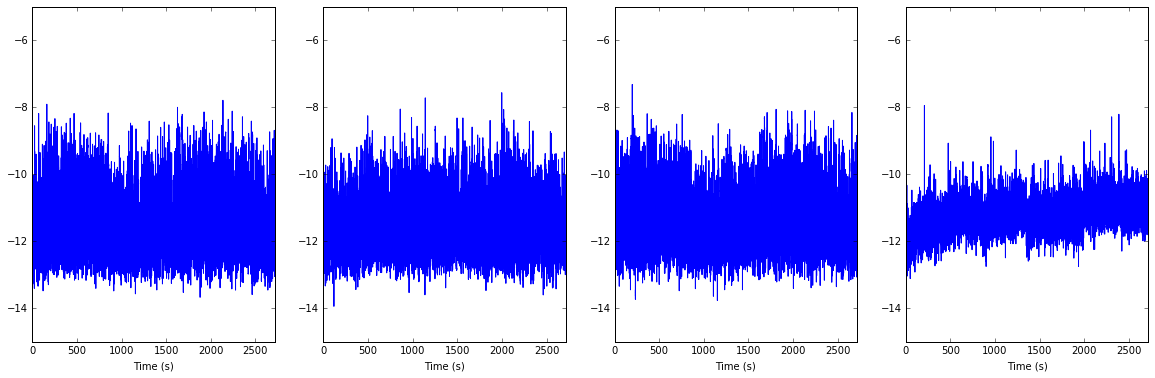

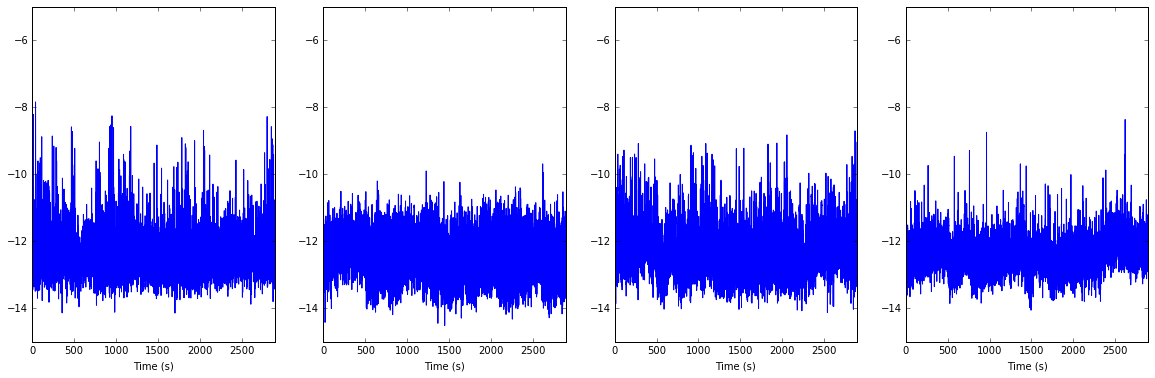

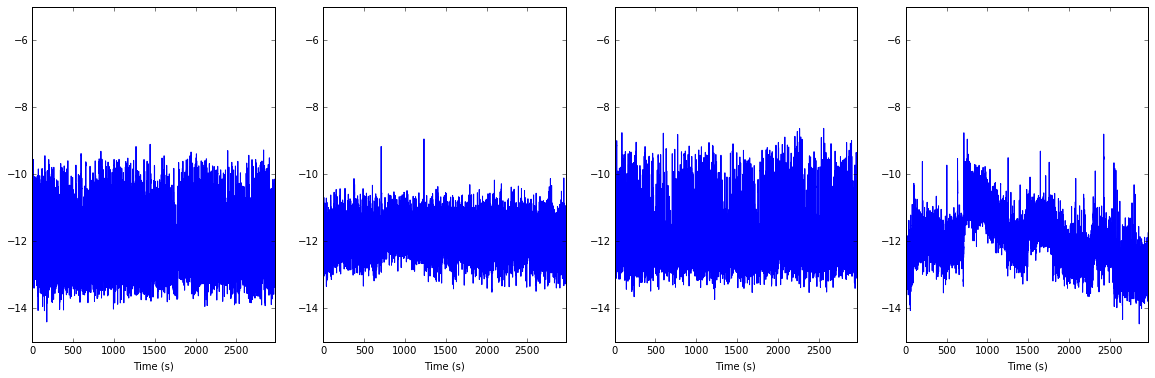

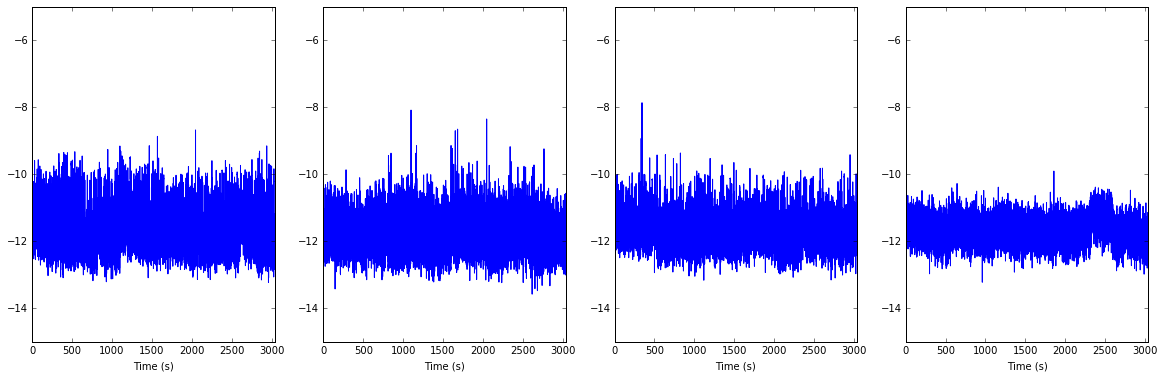

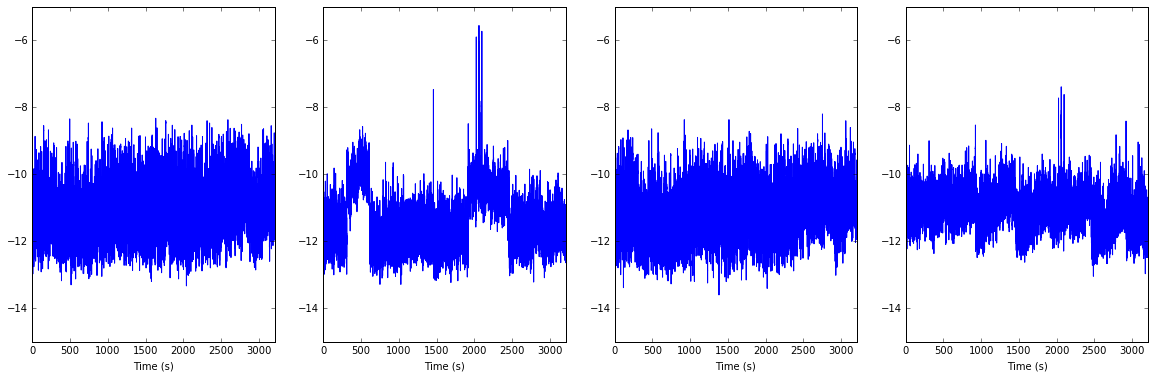

In [11]:
%matplotlib inline
##################################### Plot samples for all subjects #############################################################

for l in range(12):
    feattr = feattr_all[l]
    tmax = (len(feattr) - 1)/500
    t = np.linspace(0, tmax, len(feattr))

    f, axarr = prepare_subplot(1, 4, 6, 20)
    f.suptitle('Subject {0}'.format(l + 1))
    for k in range(4):
        axarr[k].plot(t, feattr[:,k])
        axarr[k].set_xlabel('Time (s)')
        axarr[k].set_ylim([-15, -5])
        axarr[k].set_xlim([0, tmax])
        axarr[k].set_title('Channel {0}'.format(k + 1))
    plt.show

In [10]:
def sort_points_sep(feattr, labels):
    """Sort events according to their class"""
    newf= []
    for k in range(labels.shape[1] + 1):
        newf.append([])
    cur_class = labels[0]
    cur_acc = [feattr[0]]
    for k in range(1, len(feattr)):
        lab = labels[k]
        if np.array_equal(lab, cur_class):
            cur_acc = np.concatenate((cur_acc, [feattr[k]]), axis=0)
        else:
            cur_class = lab
            if 1. in lab:
                newf[np.where(lab == 1.)[0][0] + 1].append(cur_acc)
            else:
                newf[0].append(np.array(cur_acc))
            cur_acc = [feattr[k]]
    return np.array(newf)

In [36]:
def plot_feat(sorted_sep):
    """Plot event examples according to their class"""
    f, axarr = prepare_subplot(7, 1, 24, 16)
    for k in range(7):
        for i in range(4):
            acc = sorted_sep[k][0][:,i]
            for j in range(11, 20):
                if i == 0:
                    axarr[k].axvline(float((len(acc)-1))/float(500), c='k', ls='dashed')
                acc = np.concatenate((acc, sorted_sep[k][j][:,i]), axis=0)
            tmax = float((len(acc)-1))/float(500)
            t = np.linspace(0, tmax, len(acc))
            axarr[k].plot(t, acc)
        if k == 6:
            axarr[k].set_xlabel('Time (s)')
        axarr[k].set_xlim([0, tmax])
        axarr[k].set_ylim([-16, -8])
        axarr[k].set_title('Class ' + str(k))
    return f, axarr

In [34]:
###################################### Sort events according to their class #####################################################
sorted_sep = sort_points_sep(feattr_all[0], labels_all[0])

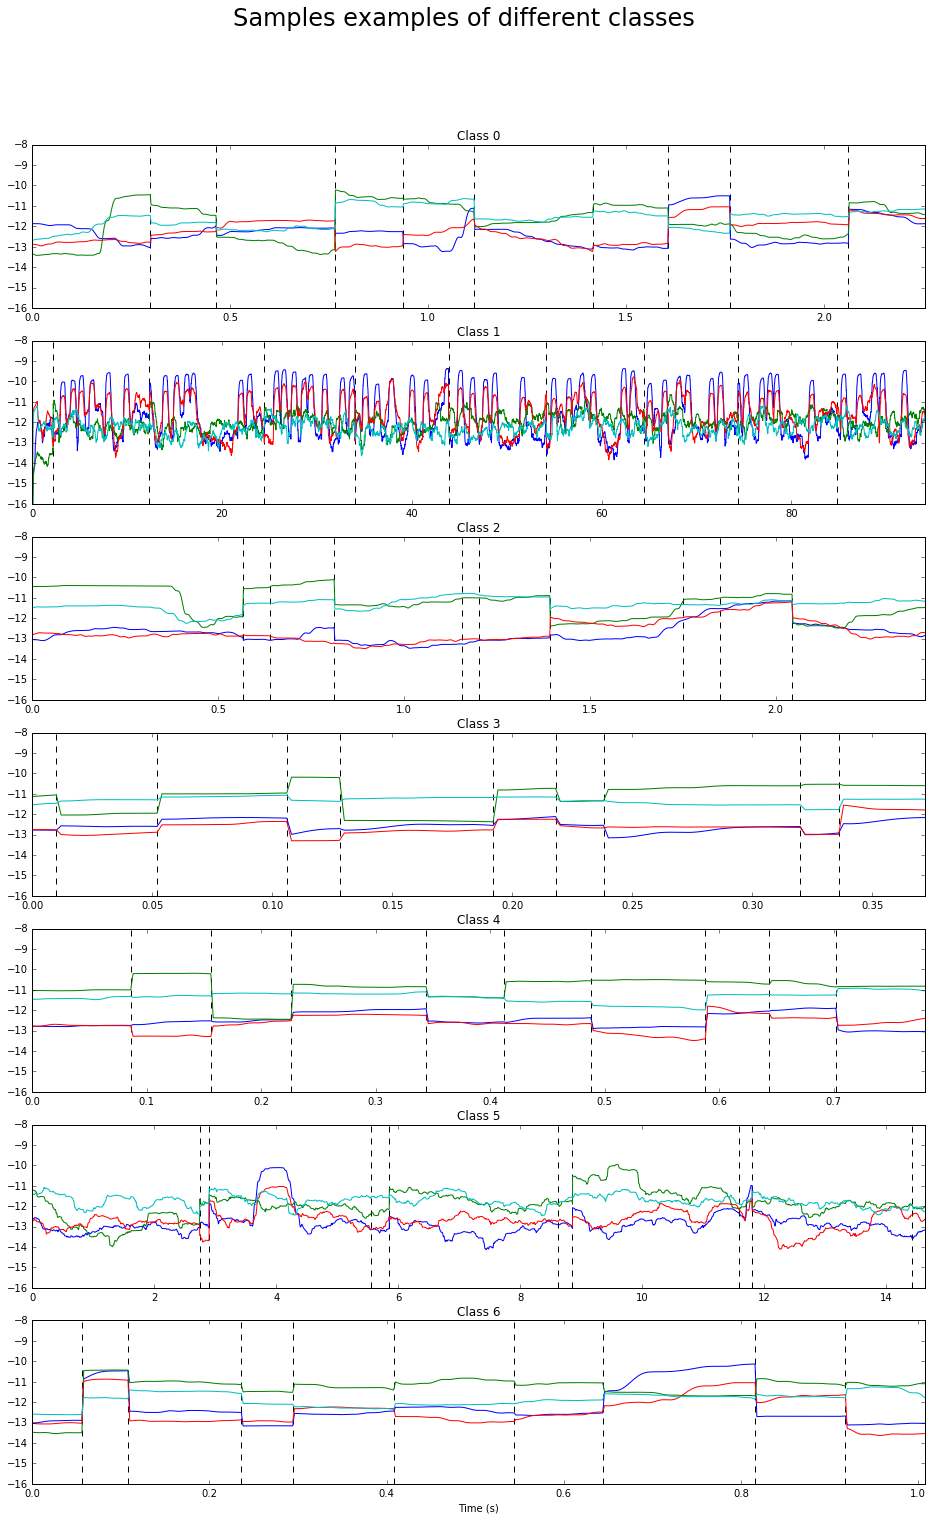

In [38]:
%matplotlib inline
############################## Plot sample examples of different classes ########################################################
f, axarr = plot_feat(sorted_sep)
f.suptitle('Samples examples of different classes', fontsize=24)
plt.show()

In [40]:
def sort_points(feattr, labels):
    """Sort samples according to their class"""
    new= []
    for k in range(labels.shape[1] + 1):
        new.append([])
    for k in range(len(feattr)):
        lab = labels[k]
        if 1. in lab:
            new[np.where(lab == 1.)[0][0] + 1].append(feattr[k])
        else:
            new[0].append(feattr[k])
    return np.array(new)

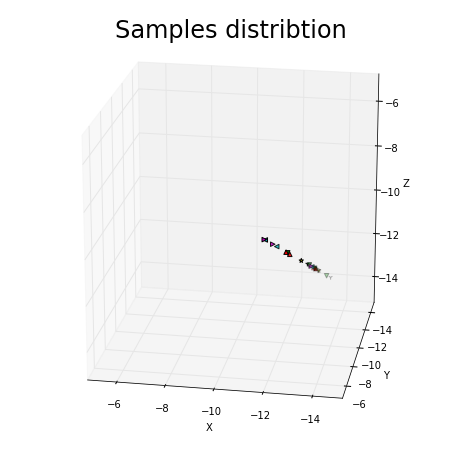

In [47]:
%matplotlib inline
######################################### Display sample distribution ##########################################################
feattr = feattr_all[0]
labels = labels_all[0]
sorted_feat = sort_points(feattr, labels)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = 'bgrcmyk'
markers = 'ov^<>*1'
for k in range(len(sorted_feat)):
    f = sorted_feat[k]
    ax.scatter(f[0], f[1], f[2], c=colors[k], marker=markers[k])
    ax.set_xlim([-15, -5])
    ax.set_xlabel('X')
    ax.set_ylim([-15, -5])
    ax.set_ylabel('Y')
    ax.set_zlim([-15, -5])
    ax.set_zlabel('Z')
    ax.view_init(elev=20, azim=100)
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('Samples distribtion', fontsize=24)
plt.show()

In [50]:
def windowed_data(feattr, labels):
    """Sort events according to their class and resize then so they have all the same length (average length) using cut 
    or repeat scheme"""
    nb_classes = labels.shape[1]
    nb_chan = feattr.shape[1]
    newf = sort_points_sep(feattr, labels)
    newl = []
    mean_len = int(np.mean([np.mean([len(f) for f in fs]) for fs in newf]))
    for k in range(len(newf)):
        for j in range(len(newf[k])):
            l = np.zeros((nb_classes))
            if k != 0:
                l[k - 1] = 1.
            newl.append(l)
            if len(newf[k][j]) > mean_len:
                newf[k][j] = newf[k][j][:mean_len]
            elif len(newf[k][j]) < mean_len:
                q = mean_len//len(newf[k][j])
                r = mean_len%len(newf[k][j])

                newf[k][j] = np.tile(newf[k][j], (q,1))
                if r != 0:
                    newf[k][j] = np.concatenate((newf[k][j], np.array(newf[k][j][:r])), axis = 0)
                
    return np.array(newf), np.array(newl)

In [62]:
def resample_data(feattr, labels, beta):
    """Sort events according to their class and resize them so they have all the same length (average length) using resample 
    scheme"""
    nb_classes = labels.shape[1]
    nb_chan = feattr.shape[1]
    newf = sort_points_sep(feattr, labels)
    newl = []
    mean_len = int(np.mean([np.mean([len(f) for f in fs]) for fs in newf]))
    for k in range(len(newf)):
        for j in range(len(newf[k])):
            l = np.zeros((nb_classes))
            if k != 0:
                l[k - 1] = 1.
            newl.append(l)
            if len(newf[k][j]) != mean_len:
                newf[k][j] = signal.resample(newf[k][j], mean_len, window=signal.get_window(('kaiser', beta), len(newf[k][j])))
    return np.array(newf), np.array(newl)

In [28]:
def mix_all(feattr, labels, rnd_state):
    """Mix events from all classes"""
    newfconc = feattr[0]
    for k in range(1, len(feattr)):
        newfconc = np.concatenate((np.array(newfconc), np.array(feattr[k])), axis = 0)

    newf, newl = shuffle(newfconc, labels, random_state = rnd_state)
    return newf, newl

In [64]:
######################################## Cut/repeat data so that they all have the same length ##################################
w_feattr_all = []
w_labels_all = []

for k in range (len(subjects)):
    feattr = feattr_all[k]
    labels = labels_all[k]
    feattr, labels = windowed_data(feattr, labels)
    w_feattr_all.append(feattr)
    w_labels_all.append(labels)

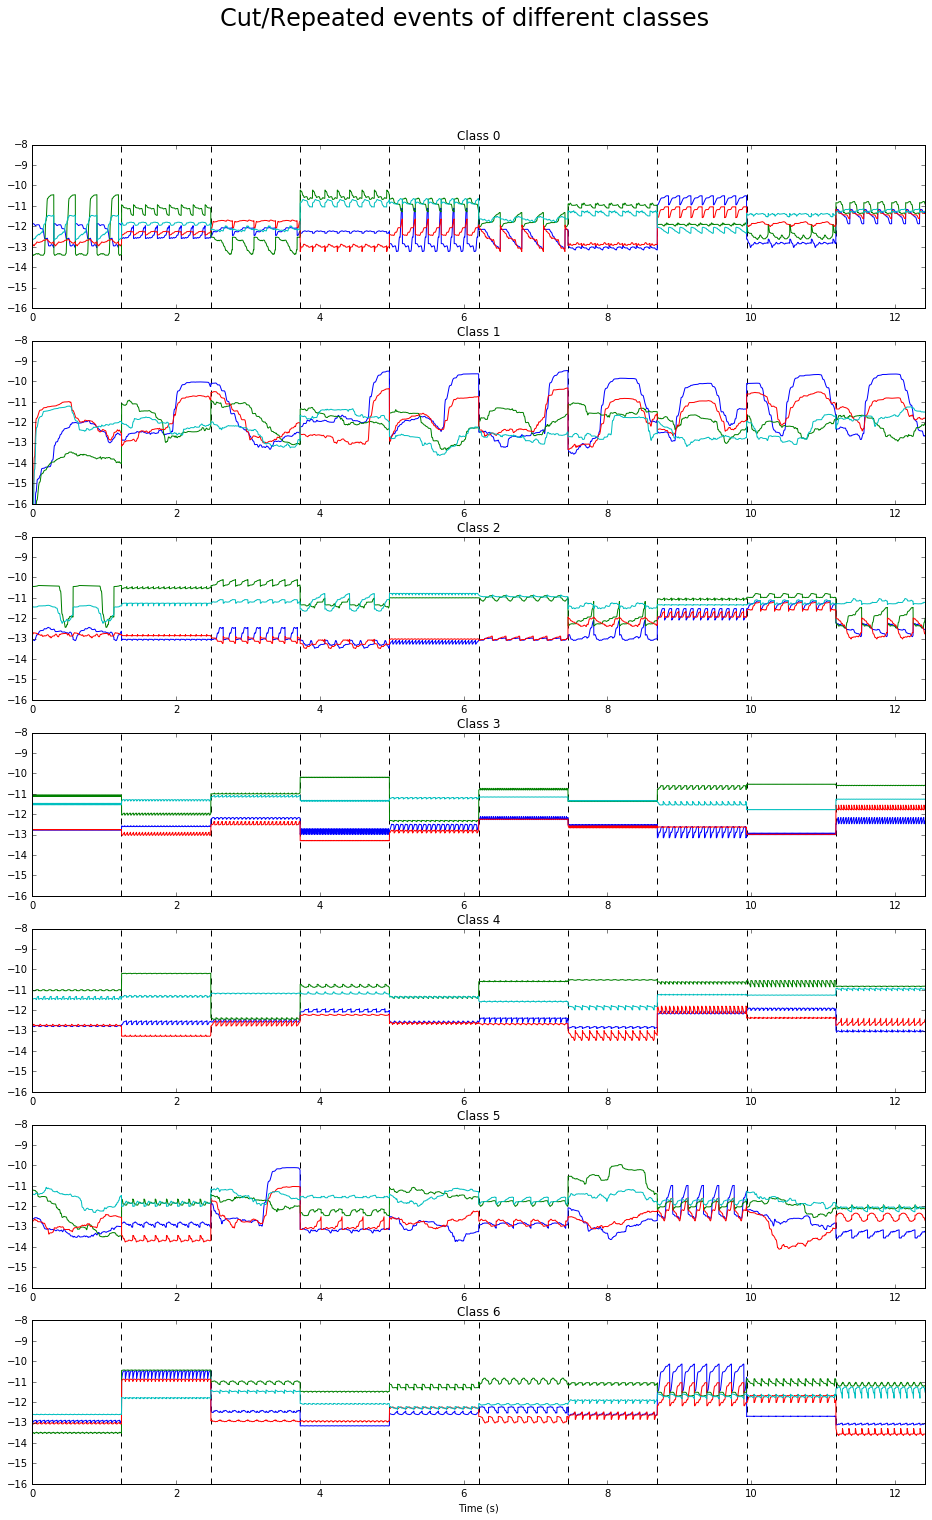

In [54]:
%matplotlib inline
#################### Plot events which have been cut or repeated to get the same length ########################################
f, axarr = plot_feat(w_feattr_all[0])
f.suptitle('Cut/Repeated events of different classes', fontsize = 24)
plt.show()

In [ ]:
########################################### Resample data in order to get the same length for each event ########################
r_feattr_all = []
r_labels_all = []

for k in range (len(subjects)):
    feattr = feattr_all[k]
    labels = labels_all[k]
    feattr, labels = resample_data(feattr, labels, 1)
    r_feattr_all.append(feattr)
    r_labels_all.append(labels)

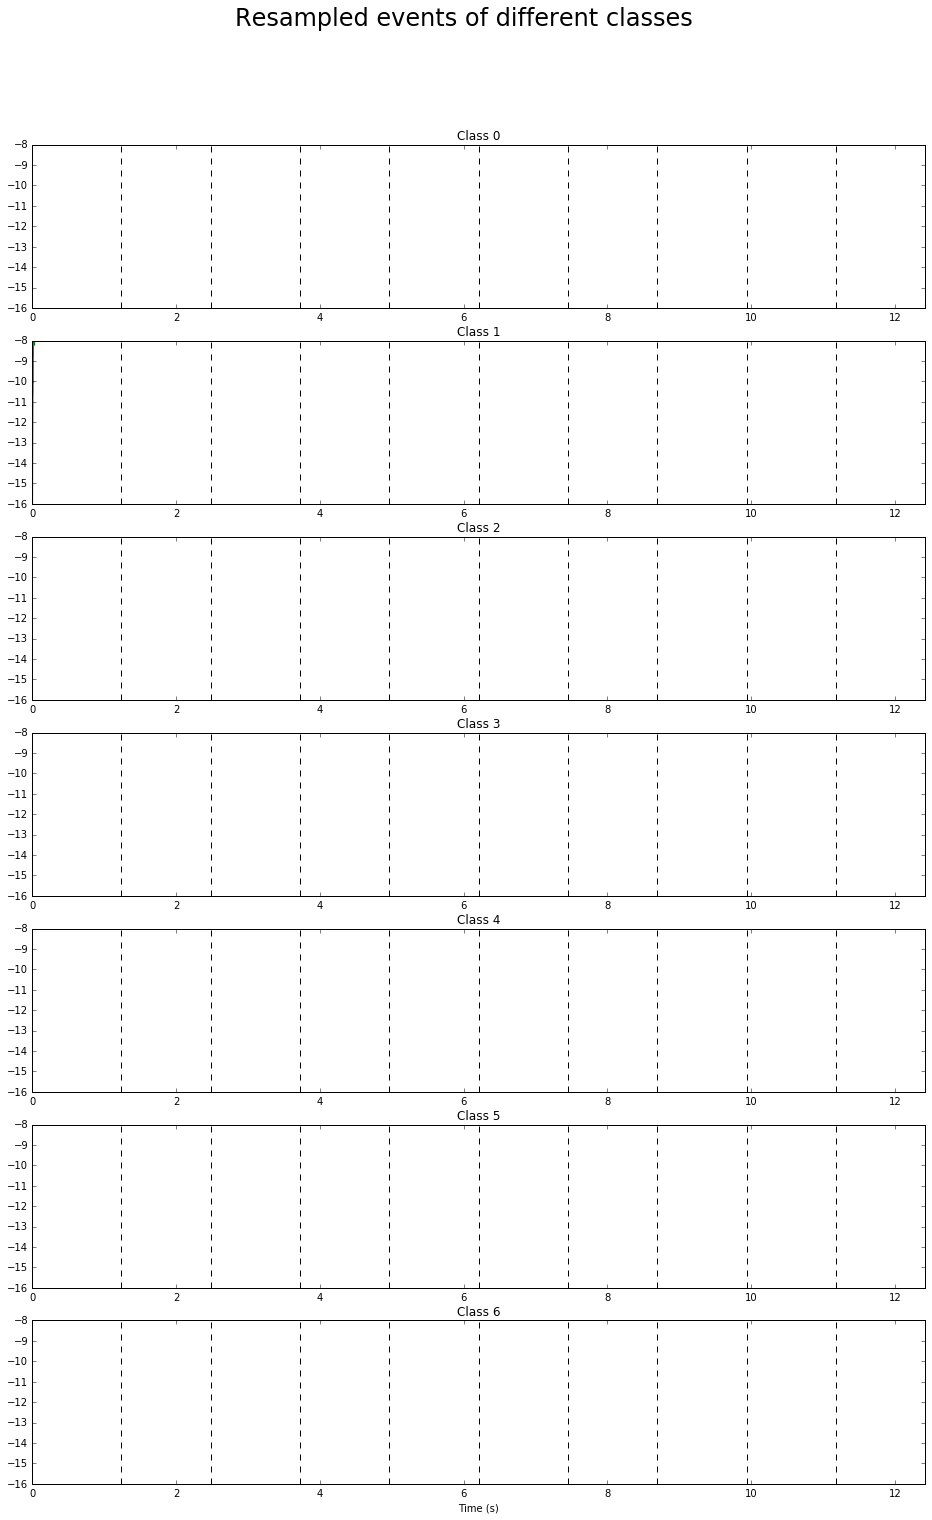

In [66]:
%matplotlib inline
######################################## Plot resampled data ####################################################################
f, axarr = plot_feat(r_feattr_all[0])
f.suptitle('Resampled events of different classes', fontsize=24)
plt.show()

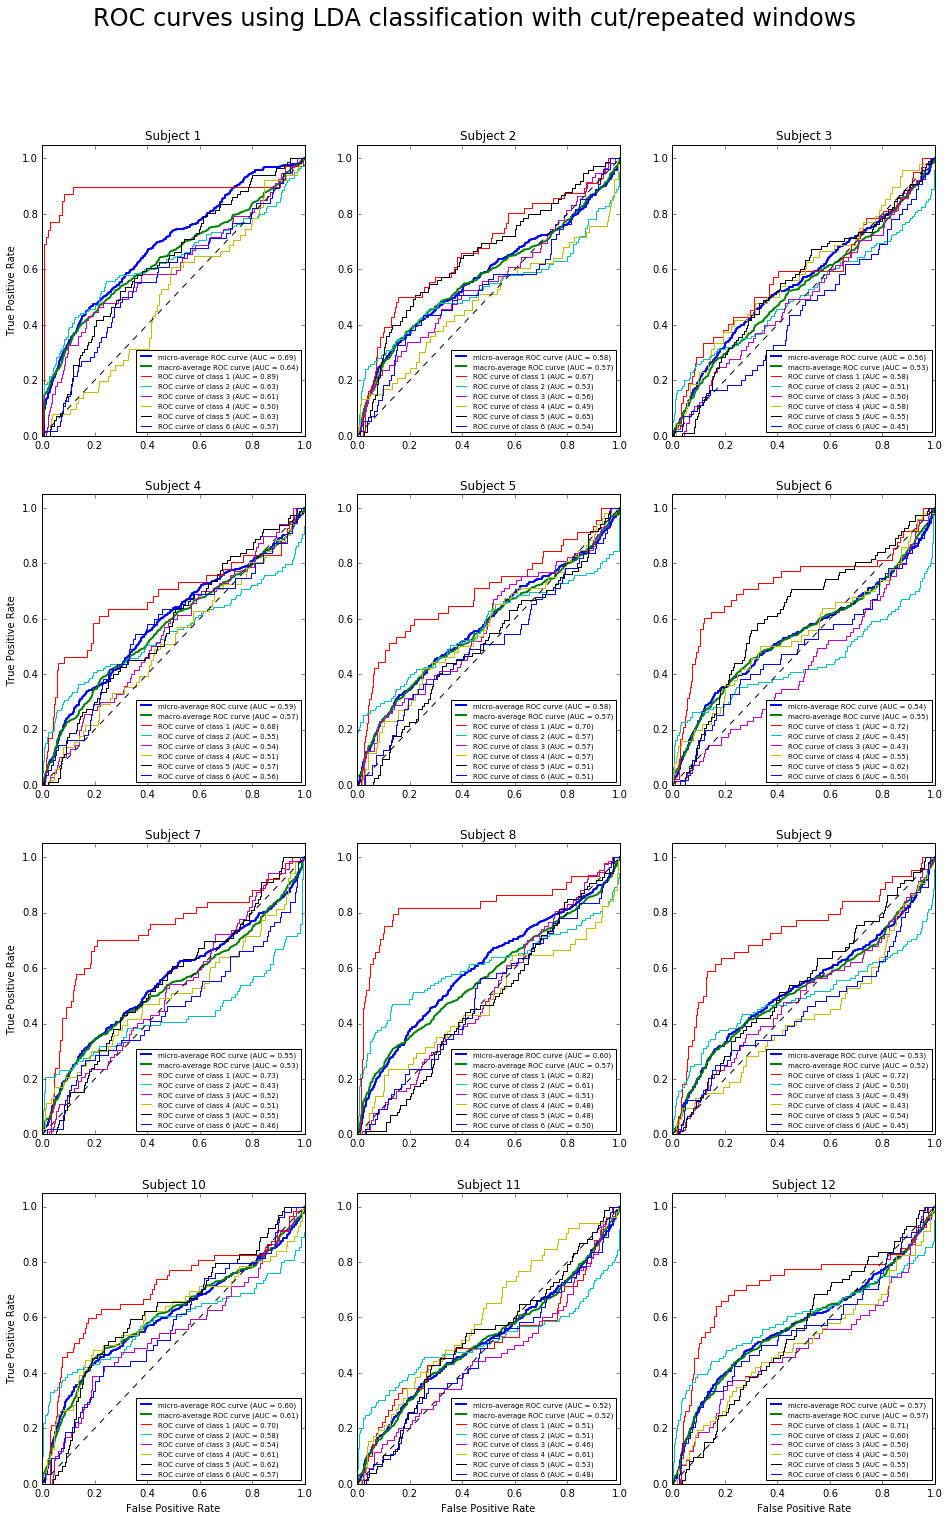

In [58]:
%matplotlib inline
##############################################  LDA cut/repeated  ###############################################################
n_classes = 6
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using LDA classification with cut/repeated windows',fontsize = 24) 

for k in range (len(subjects)):
    feattr, labels = mix_all(w_feattr_all[k], w_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

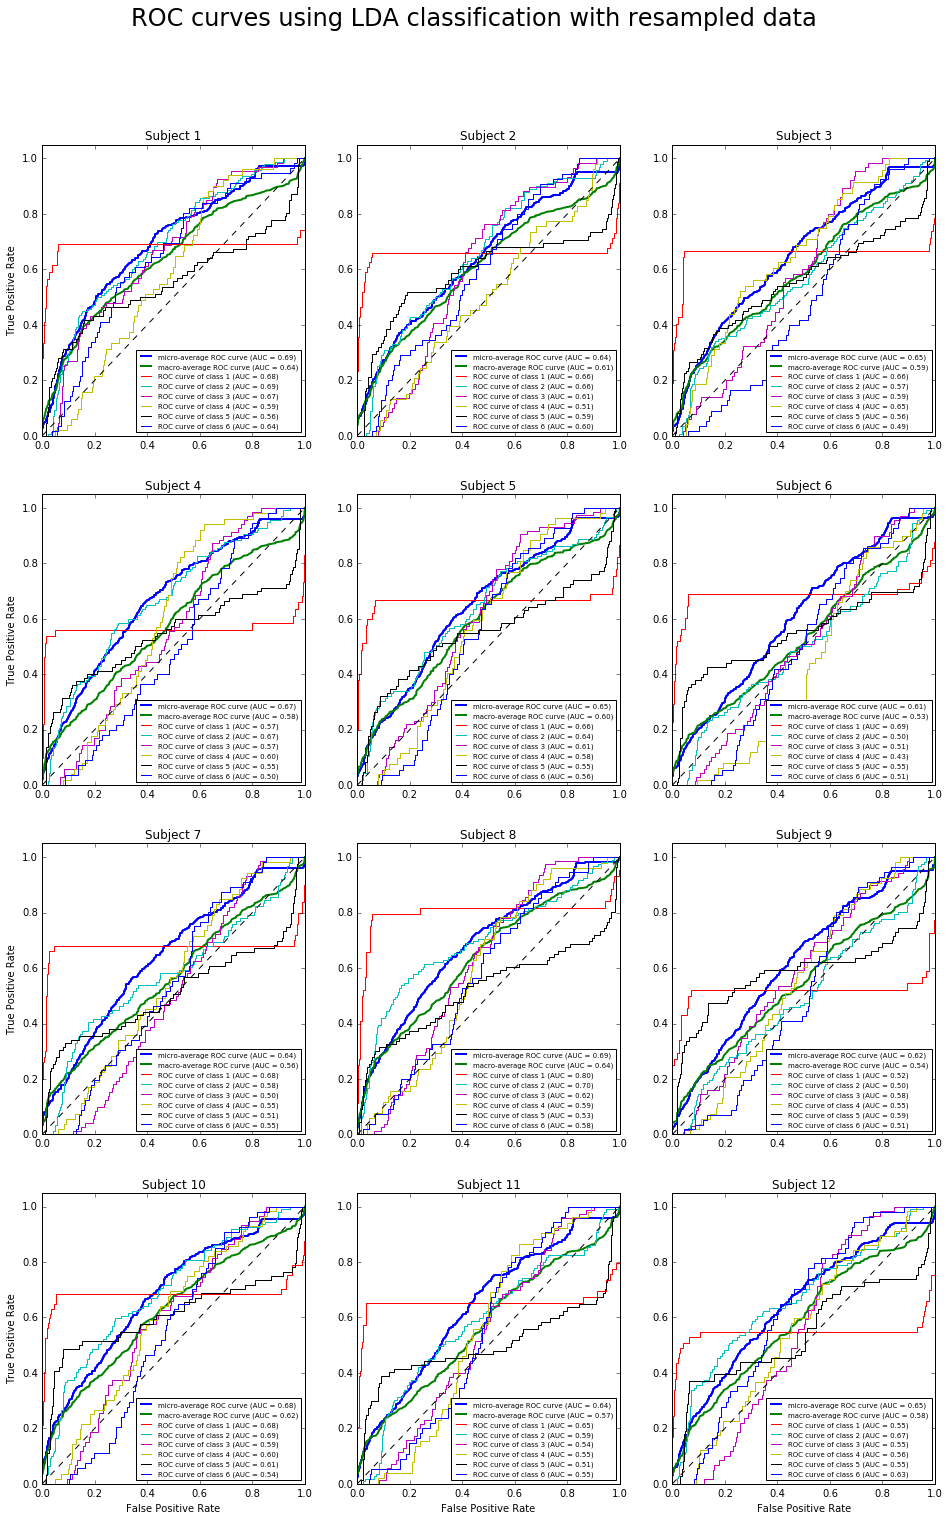

In [59]:
%matplotlib inline
##############################################  LDA resampled  ##################################################################
n_classes = 6
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using LDA classification with resampled data',fontsize = 24) 

for k in range (len(subjects)):
    #Prepare train/test data
    feattr, labels = mix_all(r_feattr_all[k], r_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

C:\Users\Martin\Miniconda2\envs\myenv\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


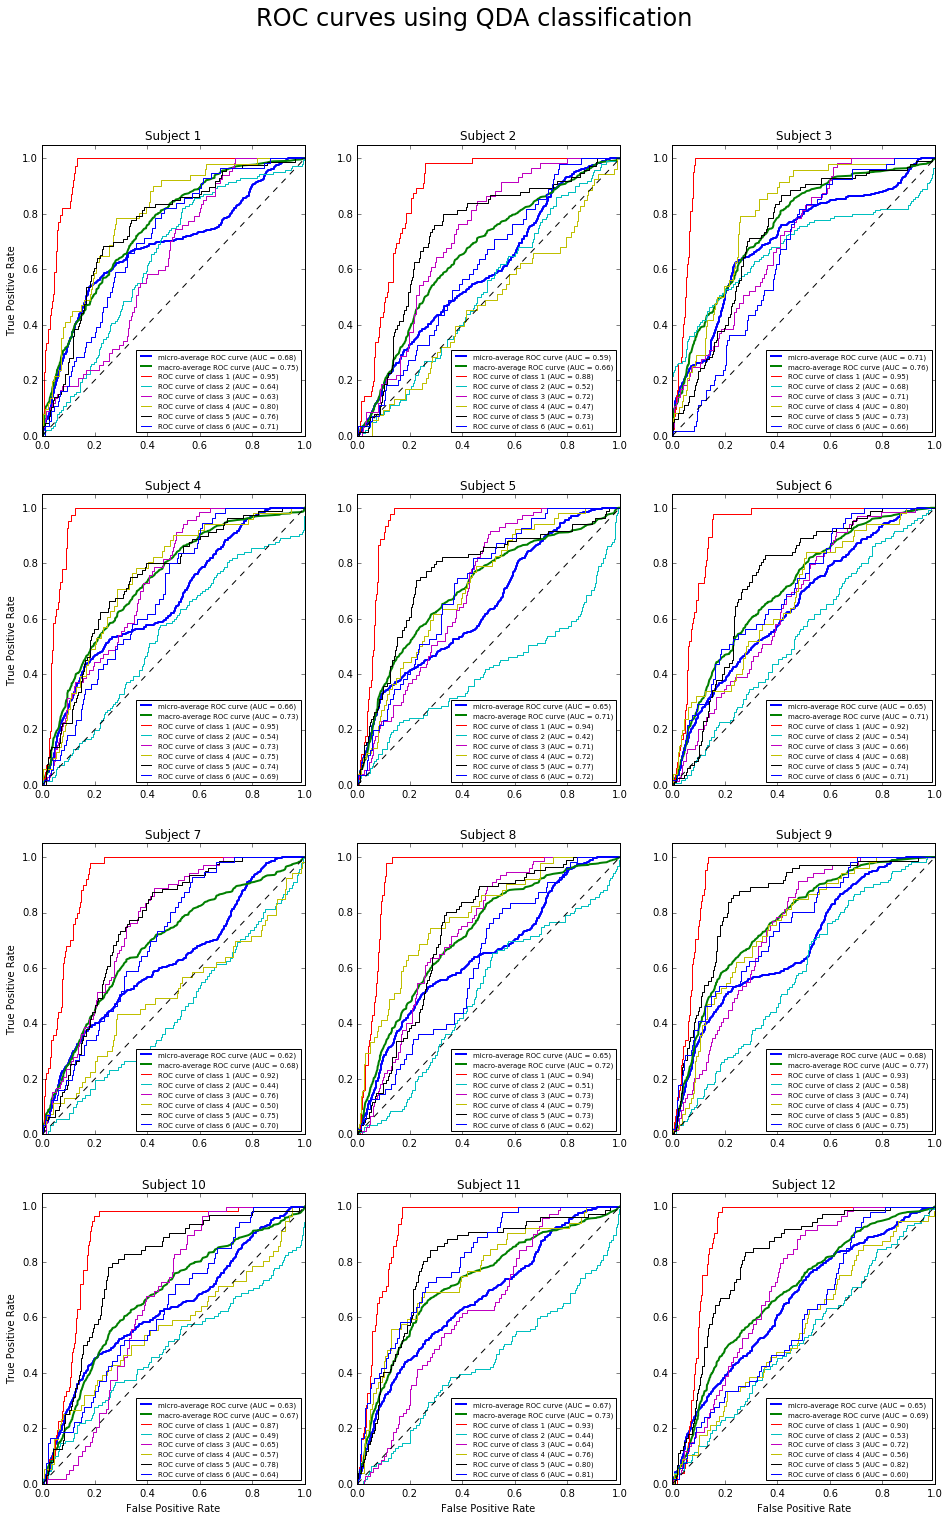

In [20]:
%matplotlib inline
##############################################  QDA cut/repeat  #################################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using QDA classification with cut/repeated data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(w_feattr_all[k], w_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(QuadraticDiscriminantAnalysis())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

C:\Users\Martin\Miniconda2\envs\myenv\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


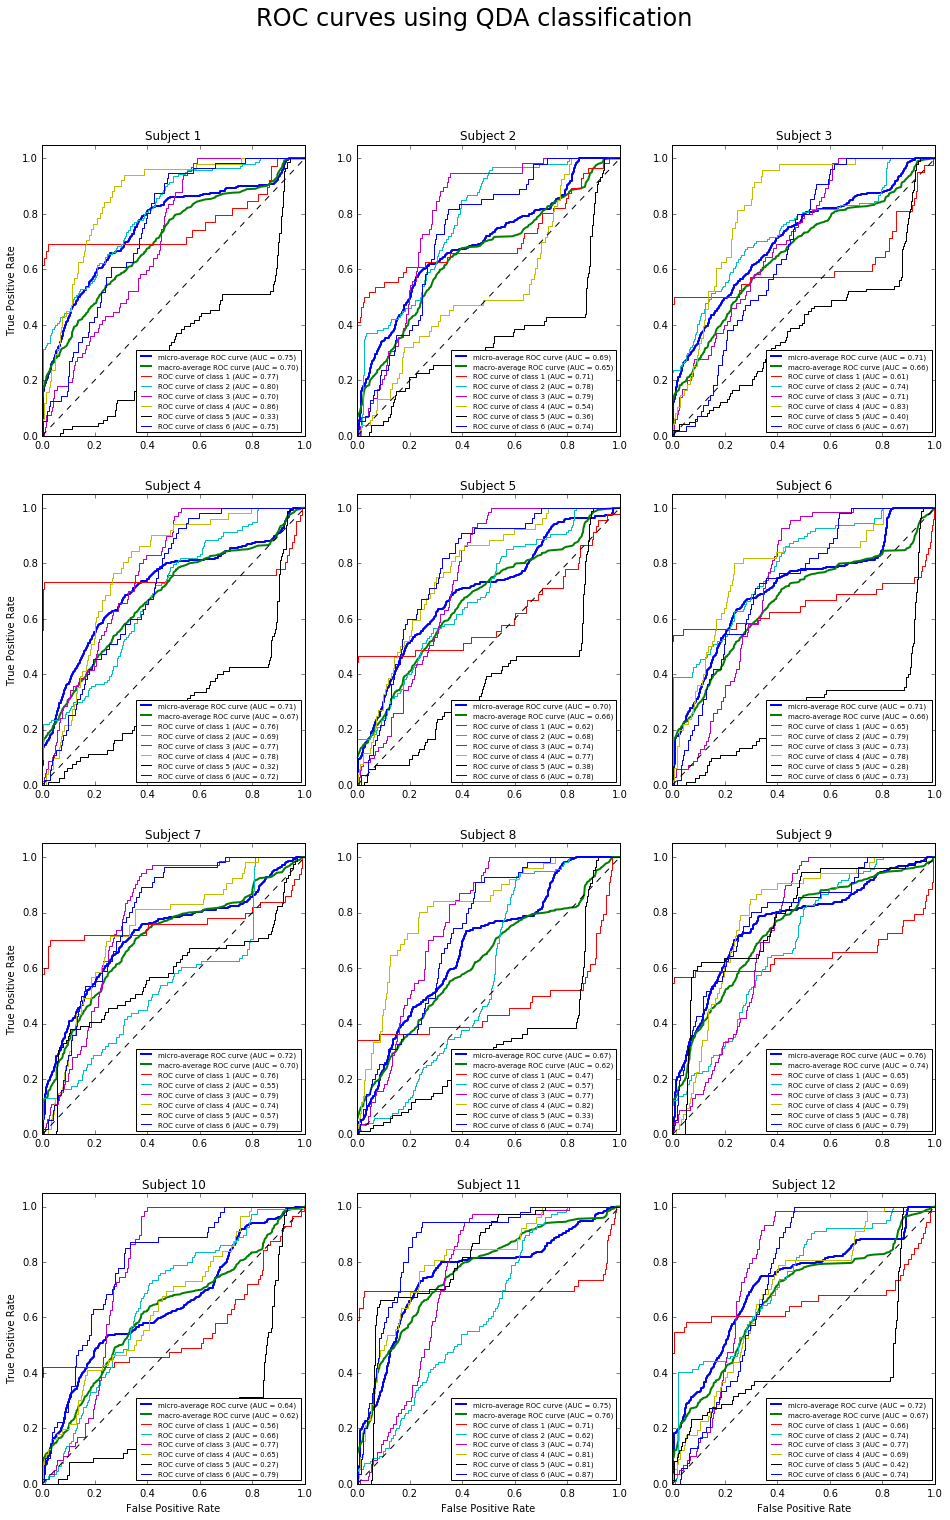

In [30]:
%matplotlib inline
##############################################  QDA classification  #############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using QDA classification',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(r_feattr_all[k], r_labels_all[k], 3)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(QuadraticDiscriminantAnalysis())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

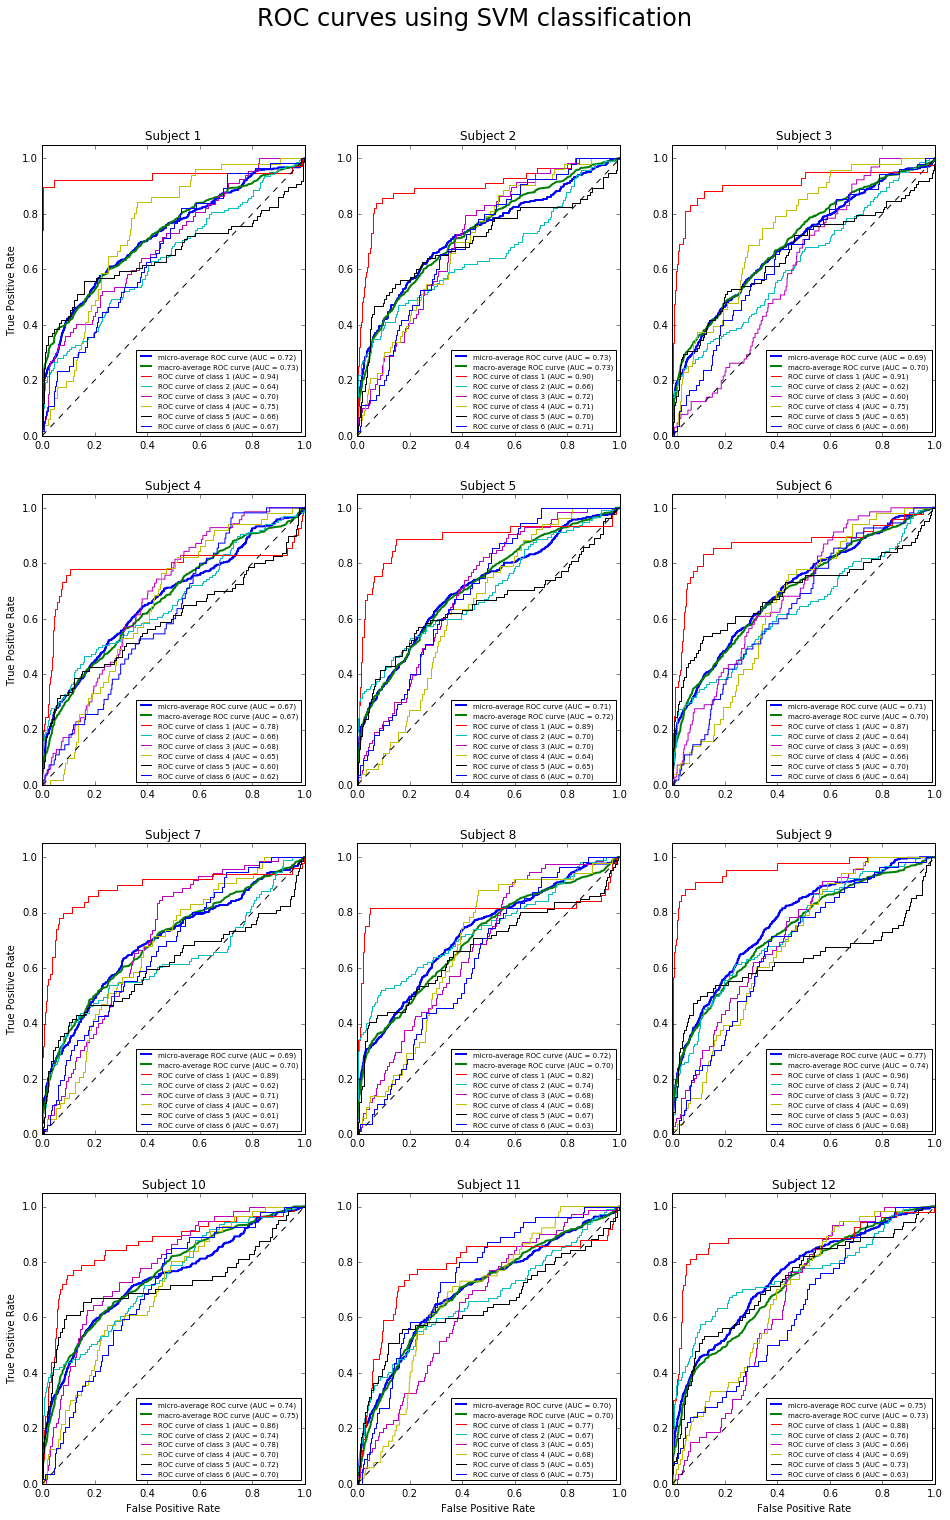

In [17]:
%matplotlib inline
##############################################  SVM cut/repeated  ###############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using SVM classification with cut/repeated data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(w_feattr_all[k], w_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(svm.SVC())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

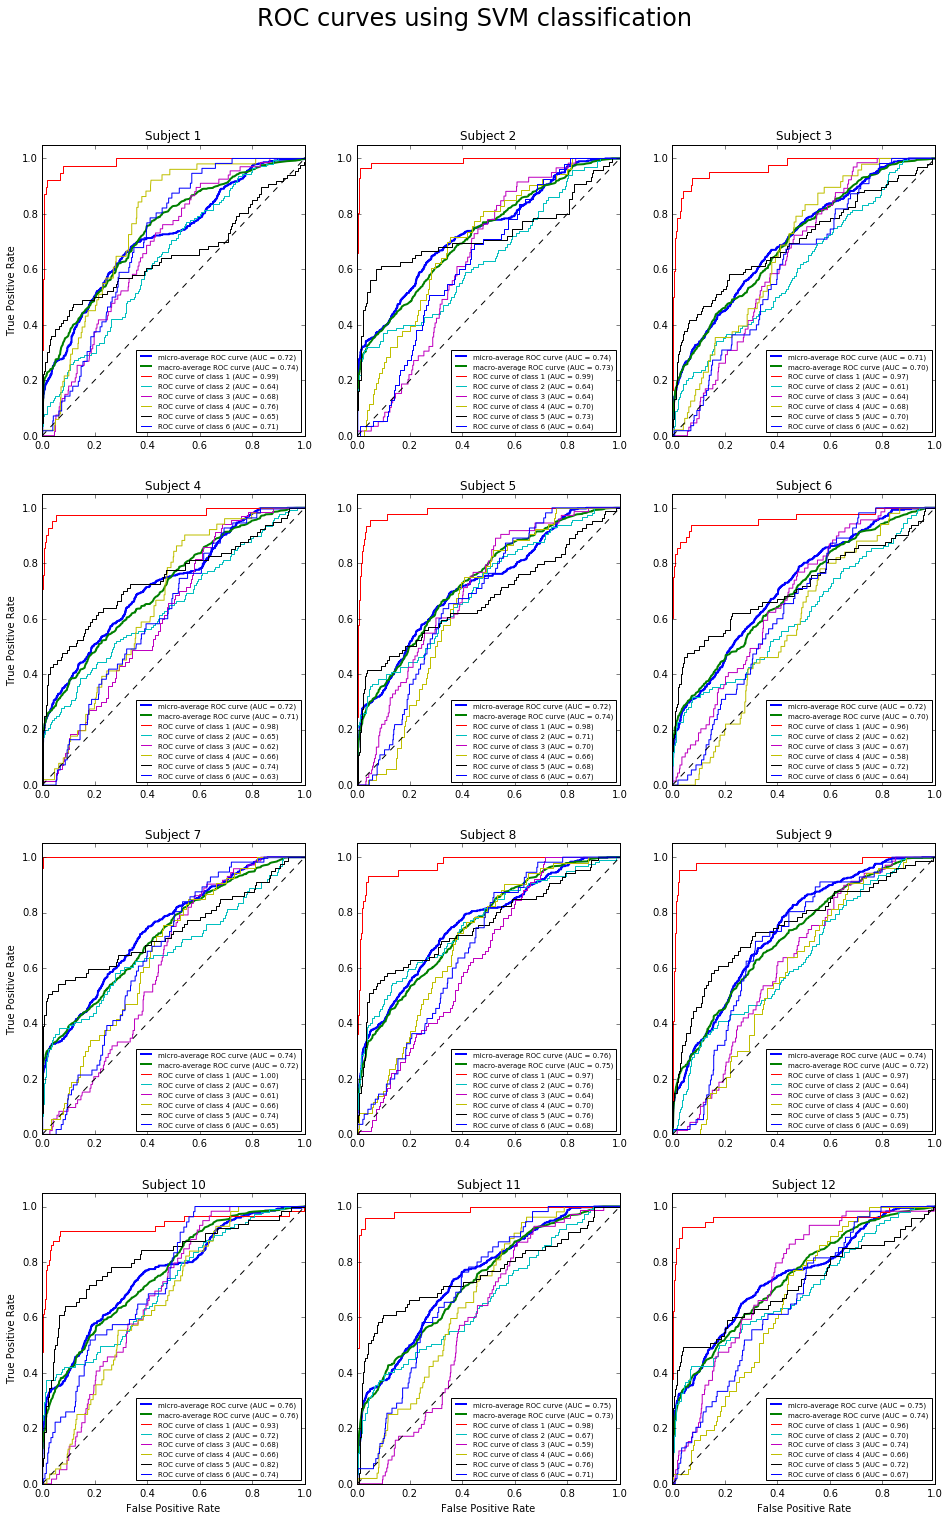

In [31]:
%matplotlib inline
##############################################  SVM classification  #############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using SVM classification',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(r_feattr_all[k], r_labels_all[k], 3)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(svm.SVC())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

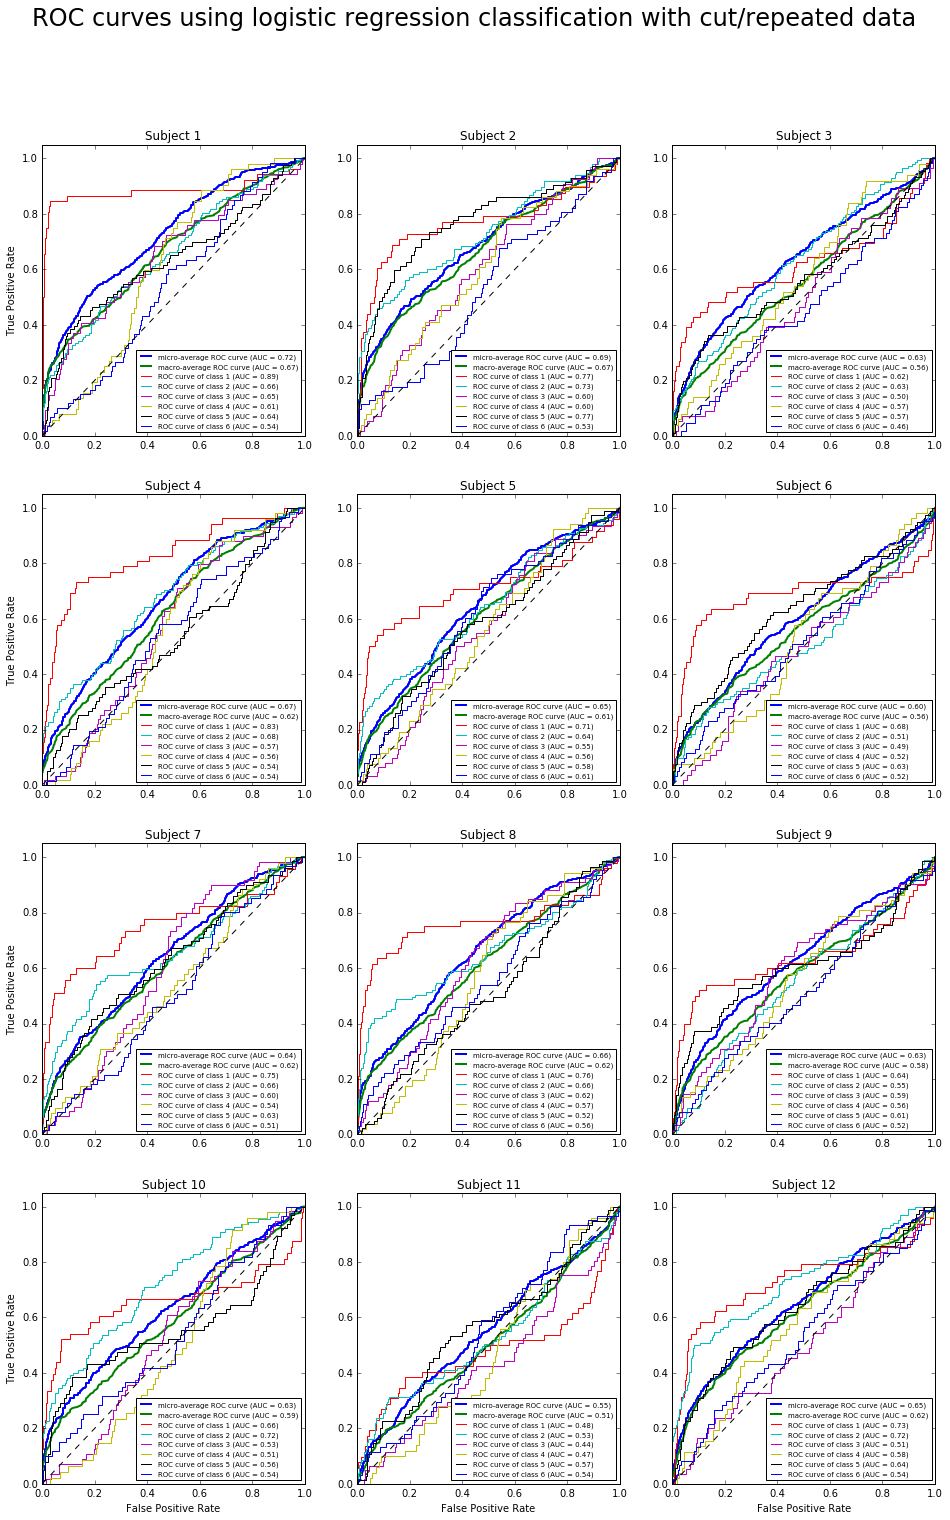

In [61]:
%matplotlib inline
##############################################  Log reg cut/repeat  #############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using logistic regression classification with cut/repeated data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(w_feattr_all[k], w_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(LogisticRegression())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

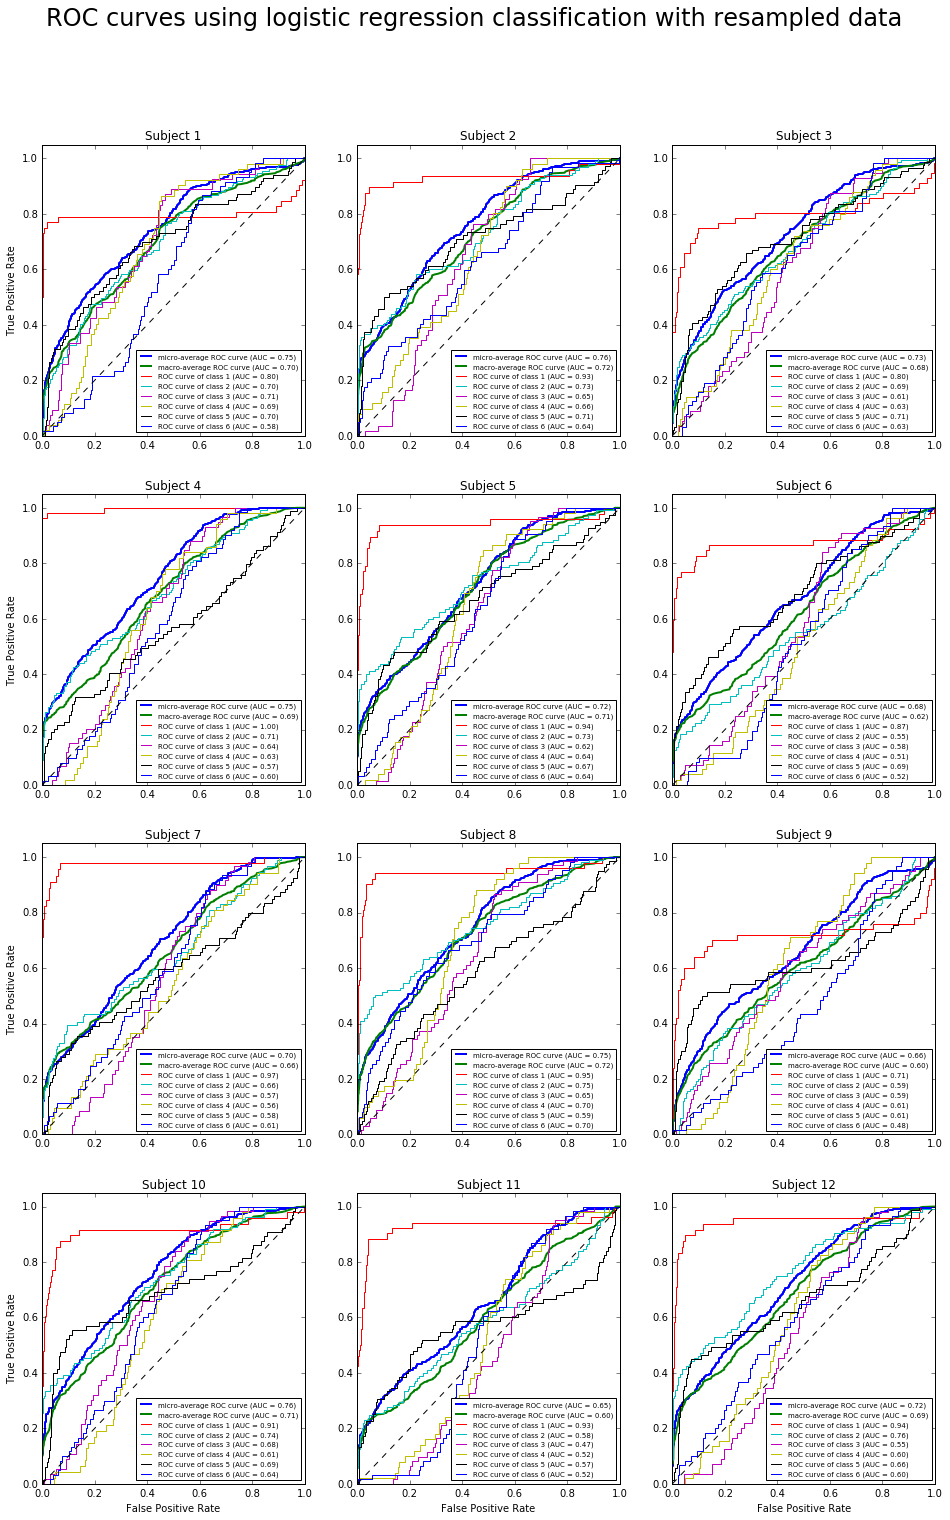

In [60]:
%matplotlib inline
##############################################  Log reg  resampled  #############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using logistic regression classification with resampled data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(r_feattr_all[k], r_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(LogisticRegression())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()